# Training of a Convolutional Neural Network to recognise character patterns inside a LM dish. 


##### Author 

Jose Miguel Serra Lleti - lleti@embl.de

This notebook corresponds to the article: _CLEMSite, a software for automated phenotypic screens using light microscopy and FIB-SEM._ 

_Please, cite the original paper if you make use of anything present in this notebook._

## Data collection and generation

In this notebook, we train a CNN to recognize alphanumerical characters. Those characters are present in Mattek grids, used in microscopy to identify locations by association with the character imprinted in the glass, below the sample. In the grid, alphanumerical characters are used. We had a total of 36 letters and numbers making combinations. Each pattern starts with 0-9, then continues with small letters from a-k, and is then followed by a second character as a big letter, from A-Z, making a total of $21*26 = 546$ distinct patterns.

For the training procedure, first is required to collect images of the grid using the microscope (e.g. with transmitted light or reflected light, in our example we use reflected light from the confocal at 10x, because it provides better clarity of the characters and improves the recognition accuracy). From those original images, saved from several experiments, we cropped some of the patterns present in the grid. 

We have gathered a total of 1125 patterns cropped from real data ( _Extracted1_ ). For this, we used CLEMSite and executed the light microscopy workflow, which extracted the squares already cleaned, binarized and with the edges enhanced. From some of those datasets, we cropped only the 36 basic characters (0-9, a-k and A-Z), cleaned them using any image editor (we used ImageJ) and saved them ( _/data/original_letters_ ). 

Using a script ( _generateSynthetic_part1.py_ ), we re-created the total of 546 patterns, corresponding to the available combinations of letters given by the manufacturer.The synthetic data is generated and the the synthetic patterns are stored in Synthetic1. The synthetic dataset is then augmented using a combination of noise (salt and pepper, gaussian, poisson, ruptures, added particles, small angle perturbations) and a sequence of dilations to simulate letters from real datasets. We generated 20 synthetic patterns for each combination of two letters ( _generateSynthetic_part2.py_ ) and we stored them in _Synthetic2_.  

Another script extracts them from folders and places them in _Extracted1_ . We combine the data from _Extracted1_ and move them to _Synthetic2_, synthetic plus real data to generate our training, validation and test datasets.


**Note: the 1125 patterns were the result of doing many experiments. However, we started acquiring images with a set large enough to comprise the basic 36 characters and then we synthetized the rest and trained the network. With later experiments, the more data we gathered, the more we added, refining further the accuracy of the model.**

### 1. Load dataset and split for training,validation and test.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import os
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from imp import reload

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:       
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print(len(gpus), "Physical GPU/s")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

def load_dataset(path):
    data = load_files(path)
    letter_files = np.array(data['filenames'])
    letter_targets = np_utils.to_categorical(np.array(data['target']), 546)
    return letter_files, letter_targets


letter_files, letter_targets = load_dataset('.\\data\\Synthetic2')


# Split in train, valid and targets
x_train, x_test, y_train, y_test = train_test_split(letter_files, letter_targets, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')
print(f'Total {x_train.shape[0]+x_valid.shape[0]+x_test.shape[0]}')

1 Physical GPUs
7164 train samples
1792 validation samples
2240 test samples
Total 11196


### 2. Visualize the First 36 Training Images

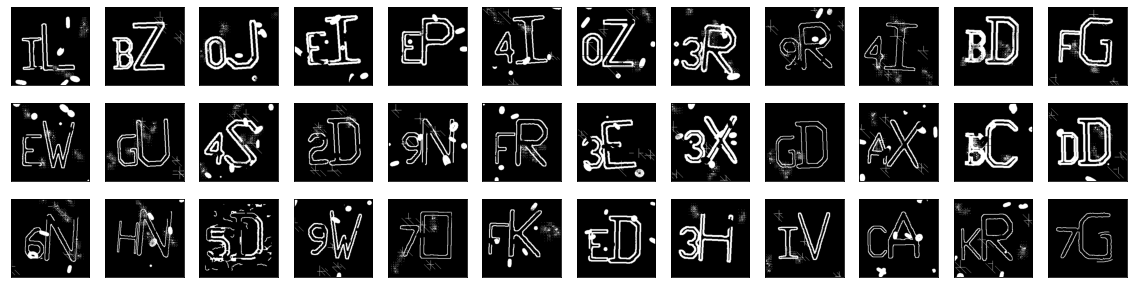

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    img = cv2.imread(x_train[i])
    ax.imshow(np.squeeze(img))

### 3. Load images and resize to 128x128
128 x 128 was found optimal to get the best tradeoff between number of network parameters and training data size. As a requirement from tensorflow, images have to be expanded to tensors and converted to floats.

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters

def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    final = cv2.resize(img,(128,128))
    final = np.array(final,dtype=np.float32)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 1) and return 4D tensor
    return np.expand_dims(final, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train)
valid_tensors = paths_to_tensor(x_valid)
test_tensors = paths_to_tensor(x_test)

100%|████████████████████████████████████████████████████████████████████████████| 2240/2240 [00:02<00:00, 1011.16it/s]


### 4.  Load images 
Additionally we read the directories to obtain a list with the real name of classes.

In [5]:
train_tensors = np.expand_dims(train_tensors, axis=3)
valid_tensors = np.expand_dims(valid_tensors, axis=3)
test_tensors = np.expand_dims(test_tensors, axis=3)

In [6]:
# Get all data names from directories
from os import listdir
from os.path import isfile, join

adir = ".\\data\Synthetic2"
my_letters = [f for f in listdir(adir) if not isfile(join(adir, f))]
str(my_letters)

"['0A', '0B', '0C', '0D', '0E', '0F', '0G', '0H', '0I', '0J', '0K', '0L', '0M', '0N', '0O', '0P', '0Q', '0R', '0S', '0T', '0U', '0V', '0W', '0X', '0Y', '0Z', '1A', '1B', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K', '1L', '1M', '1N', '1O', '1P', '1Q', '1R', '1S', '1T', '1U', '1V', '1W', '1X', '1Y', '1Z', '2A', '2B', '2C', '2D', '2E', '2F', '2G', '2H', '2I', '2J', '2K', '2L', '2M', '2N', '2O', '2P', '2Q', '2R', '2S', '2T', '2U', '2V', '2W', '2X', '2Y', '2Z', '3A', '3B', '3C', '3D', '3E', '3F', '3G', '3H', '3I', '3J', '3K', '3L', '3M', '3N', '3O', '3P', '3Q', '3R', '3S', '3T', '3U', '3V', '3W', '3X', '3Y', '3Z', '4A', '4B', '4C', '4D', '4E', '4F', '4G', '4H', '4I', '4J', '4K', '4L', '4M', '4N', '4O', '4P', '4Q', '4R', '4S', '4T', '4U', '4V', '4W', '4X', '4Y', '4Z', '5A', '5B', '5C', '5D', '5E', '5F', '5G', '5H', '5I', '5J', '5K', '5L', '5M', '5N', '5O', '5P', '5Q', '5R', '5S', '5T', '5U', '5V', '5W', '5X', '5Y', '5Z', '6A', '6B', '6C', '6D', '6E', '6F', '6G', '6H', '6I', '6J', '6

### 5. Create and Configure Augmented Image Generator
Although the data was already augmented, a small range of augmentations is always desired to achieve better performance. It is important to give horizontally flipped images and some zoom and pan range.

In [7]:
# create and configure augmented image generator using keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')


# fit augmented image generator on data
datagen.fit(train_tensors)

### 6. Visualize Original and Augmented Images

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 799.98it/s]


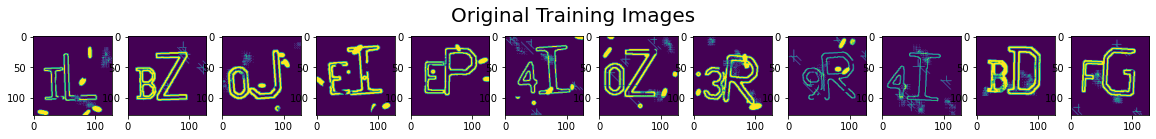

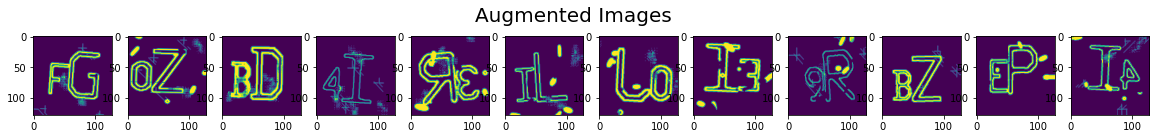

In [8]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = paths_to_tensor(x_train[:12])

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen.flow(train_tensors[:12], batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i,:,:,0])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

The architecture used is based on the paper *Bui and Chang,'Deep Learning Architectures for Hard Character Classification', ICAI 2016*. The architecture used is similar with additional modifications : we used dropouts (*Hinton et al."Improving neural networks by preventing co-adaptation of feature detectors", 2012*) starting at 0.1 and increasing at the end to be 0.5 for the fully connected layer; a batch normalization before a max pooling layer (*Ioffe et al.,"Batch normalization: Accelerating deep network training by reducing internal covariate shift", 2015*) and a global average pooling instead of a flatten layer previous to the fully connected layer. Additionally, instead of having a fully connected layer of 546, we added a pre intermediated layer with 192 nodes (number of features extracted from the CNN and weighted to decide the final class). The resultant network has a total of 400,514 parameters.

The encoder-decoder simplicity of the current model, makes it ready to try it with any type of printed patterns. This architecture is, however, not a state of the art. It is likely that better network models, e.g., using spatial attention or bigger networks (transformers) with pretrained weights could probably increase the accuracy of the current model.  Future implementations could replace the model by a newer one (e.g. EfficientNet, Tan et al.2019, https://arxiv.org/abs/1905.11946), increasing the accuracy in detection, or allowing the use of transmitted light or DIC in light microscopy. 


In [33]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(546, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 64)       

### 8. Compile the Model 
The model will be trained using categorical crossentropy with Root Mean Square error for backpropagation. 

In [34]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model

A batch size of 20 with 50 epochs was found optimal after several trials. The number 50 in the epochs parameter was chosen to observe how the loss from validation and train converge steadily to a plateau. We use checkpoints to obtain the best accuracy-loss trade off.

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.callbacks import ModelCheckpoint,EarlyStopping  

batch_size = 20
epochs = 60

# train the model
checkpointer = ModelCheckpoint(filepath='letters_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
   

early_stop = EarlyStopping(monitor='loss', patience=6)
    
hist = model.fit(
        datagen.flow(train_tensors, y_train,batch_size=batch_size),
        steps_per_epoch= y_train.shape[0] // batch_size,
        epochs=epochs,
        verbose =2,
        callbacks = [checkpointer, early_stop],
        validation_data= datagen.flow(valid_tensors, y_valid,batch_size=batch_size),
        validation_steps= y_valid.shape[0] // batch_size)


Epoch 1/60
 - 10s - loss: 6.3061 - accuracy: 0.0028 - val_loss: 6.2704 - val_accuracy: 0.0090

Epoch 00001: val_loss improved from inf to 6.27043, saving model to letters_model.weights.best.hdf5
Epoch 2/60
 - 8s - loss: 5.8813 - accuracy: 0.0091 - val_loss: 5.9581 - val_accuracy: 0.0119

Epoch 00002: val_loss improved from 6.27043 to 5.95813, saving model to letters_model.weights.best.hdf5
Epoch 3/60
 - 8s - loss: 5.3721 - accuracy: 0.0211 - val_loss: 4.6751 - val_accuracy: 0.0367

Epoch 00003: val_loss improved from 5.95813 to 4.67505, saving model to letters_model.weights.best.hdf5
Epoch 4/60
 - 8s - loss: 4.7999 - accuracy: 0.0466 - val_loss: 4.3060 - val_accuracy: 0.0457

Epoch 00004: val_loss improved from 4.67505 to 4.30600, saving model to letters_model.weights.best.hdf5
Epoch 5/60
 - 8s - loss: 4.2711 - accuracy: 0.0747 - val_loss: 3.4201 - val_accuracy: 0.1258

Epoch 00005: val_loss improved from 4.30600 to 3.42014, saving model to letters_model.weights.best.hdf5
Epoch 6/60
 -


Epoch 00049: val_loss did not improve from 0.00021
Epoch 50/60
 - 7s - loss: 0.2972 - accuracy: 0.9124 - val_loss: 6.8873e-04 - val_accuracy: 0.9910

Epoch 00050: val_loss did not improve from 0.00021
Epoch 51/60
 - 8s - loss: 0.2969 - accuracy: 0.9108 - val_loss: 0.0138 - val_accuracy: 0.9848

Epoch 00051: val_loss did not improve from 0.00021
Epoch 52/60
 - 8s - loss: 0.2809 - accuracy: 0.9166 - val_loss: 0.0027 - val_accuracy: 0.9876

Epoch 00052: val_loss did not improve from 0.00021
Epoch 53/60
 - 8s - loss: 0.2915 - accuracy: 0.9159 - val_loss: 0.0014 - val_accuracy: 0.9814

Epoch 00053: val_loss did not improve from 0.00021
Epoch 54/60
 - 7s - loss: 0.2715 - accuracy: 0.9190 - val_loss: 0.6640 - val_accuracy: 0.9870

Epoch 00054: val_loss did not improve from 0.00021
Epoch 55/60
 - 7s - loss: 0.2806 - accuracy: 0.9218 - val_loss: 0.0011 - val_accuracy: 0.9876

Epoch 00055: val_loss did not improve from 0.00021
Epoch 56/60
 - 7s - loss: 0.2853 - accuracy: 0.9191 - val_loss: 1.82

### 10. Load the Model with the Best Validation Accuracy

In [30]:
# load the weights that yielded the best validation accuracy
model.load_weights('letters_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

After a proper evaluation of the loss function, we proceed to report the accuracy of our network using the test set.  

Text(0.5, 0, 'Epoch')

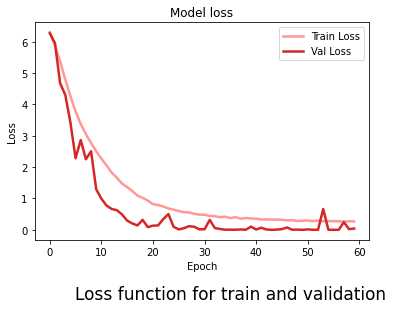

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt

colortable = [(255, 152, 150), (214, 39, 40)]  

for i in range(len(colortable)):  
    r, g, b =   colortable[i]
    colortable[i] = (r / 255., g / 255., b / 255.)  
    
plt.plot(hist.epoch, hist.history['loss'], lw=2.5, color = colortable[0])    
plt.plot(hist.epoch, hist.history['val_loss'], lw=2.5, color= colortable[1])  
plt.text(35, -2.2, "Loss function for train and validation", fontsize=17, ha="center")  
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [35]:
# report test accuracy
score = model.evaluate(test_tensors, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1]*100)


 Test accuracy: 0.1785714295692742


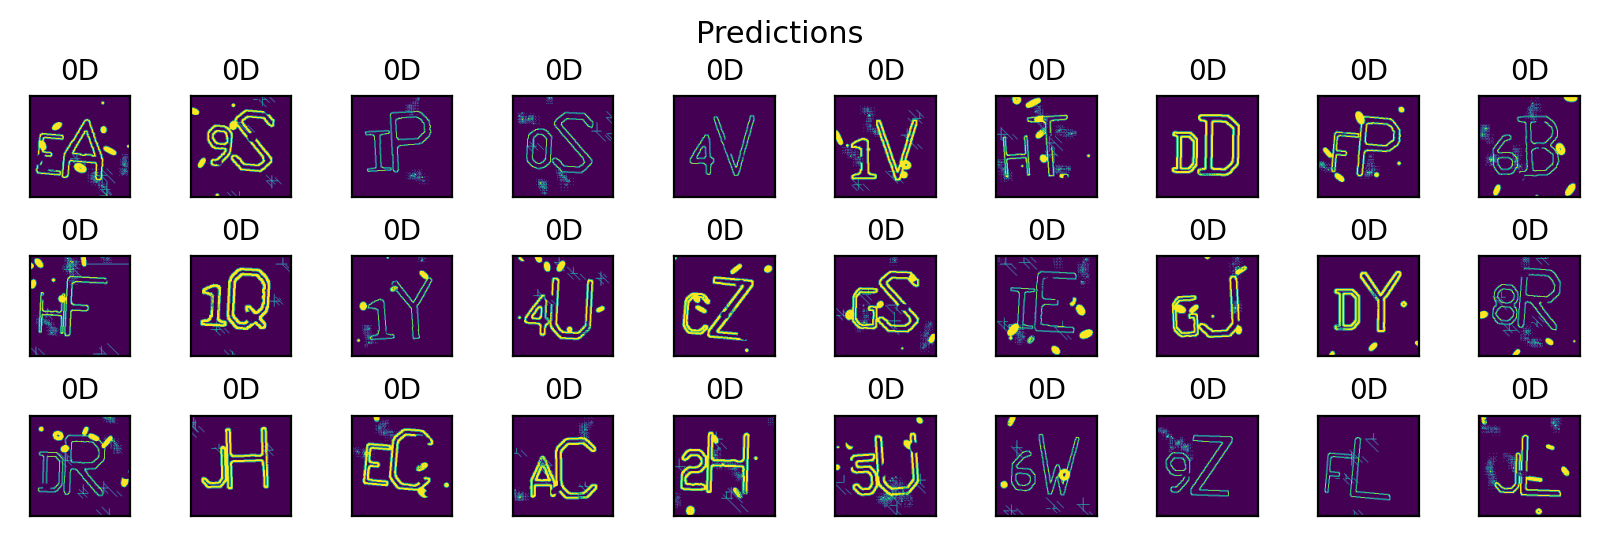

In [36]:
# get index of predicted character for each image in the test set
letter_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# visualize subset of test data plus predictions
fig = plt.figure(figsize=(10,3),dpi=200)

for i in range(0,30):
    ax = fig.add_subplot(3, 10, i+1)
    ax.set_title(my_letters[letter_predictions[i]],fontsize=10)
    ax.set_xticklabels(())
    ax.set_xticks([])
    ax.set_yticklabels(())
    ax.set_yticks([])
    img = test_tensors[i,:,:,0]
    ax.imshow(img)
fig.suptitle('Predictions', fontsize=11)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.6, hspace=None)
plt.show()

my_votes = [ my_letters[lp] for lp in letter_predictions ]

### 12. Selective output
Even if we achieved a great performance with our classifier (in test, and with a high percentage of similar synthetic data), it is possible to increase the chances of being right in our classification based on the position of the microscope. Usually, the microscope moves to a specific position on the surface grid, where one of the patterns is present. We can guess more or less the position of the square inside the grid, for example, by taking several known positions in the grid and computing a linear model. Even if the model has a big error, the current position is going to be located always inside an area not bigger than $x$ mm radius (e.g. 2 mm), smaller than, e.g., 25 squares. That is a small subset of patterns from the total of 546. If we know a subset that contains for sure the output pattern, we can narrow the output probabilities zeroing out the classes that are far away from the region of our current position.

 To have the right probability outputs, we have to change the output of the classifier to be linear instead of softmax. Then, we apply softmax to the subset of linear selected outputs.

In [37]:
# We could load the old model and replace the last layer.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Generate model with linear output
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(546, activation='linear'))

In [38]:
# Save model to use later with serialization to JSON
model_json = model.to_json()
with open("model_letters.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model letters to disk")


model.save('model_letters.h5')

Saved model letters to disk


In [39]:
model.load_weights('letters_model.weights.best.hdf5')

def predictPattern(image_pattern,model, subset=[]):
    """
        Given a image and a model, converts to tensor and gives back the result of a prediction by the model.
        If a subset of the classes of the model is provided, puts to 0 all non-valid classes and re calculates
        probabilities using a softmax.
    """
    if subset:
        valid_tags = [ el in subset for el in my_letters ]
        valid_tags = np.array(valid_tags,dtype = np.float32)
        non_valid_indexes = [ind for ind, el in enumerate(valid_tags) if el == 0.0]
        valid_indexes = [ind for ind, el in enumerate(valid_tags) if el != 0.0]
    results = model.predict(np.expand_dims(image_pattern, axis=0))[0]
    if subset:
        minimum_value = np.min(results[valid_indexes]) #normalization
        results[valid_indexes] = results[valid_indexes] - minimum_value
        results[non_valid_indexes] = 0.0
        results = softmax(results)
    return results

def getNeighbors(cletter,N = 2):
    xlabels = '0123456789ABCDEFGHIJK'
    ylabels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    poslminus = xlabels.find(cletter[0])
    poslplus = ylabels.find(cletter[1])
    Nband = int(N)
    neighs = []
    for i in range(poslminus-Nband,poslminus+Nband+1):
        if i < len(xlabels) and i > -1:
            minusl = xlabels[i]
            for j in range(poslplus-Nband,poslplus + Nband + 1):
                if j < len(ylabels) and j > -1:
                    plusl = ylabels[j]
                    neighs.append(minusl+plusl)
    return neighs

def softmax(y):
    s = np.exp(np.array(y,dtype=np.float64)) 
    y_prob = np.divide(s,np.sum(s),where=s>0)
    return y_prob

In [40]:
# Get neighbors of real classes.
# Imagine our linear model tells our position is somewhere close to  2S. Then, we can grab all surrounding neighbors.
# N =1, gets all surrounding squares, N=2, considers 2 squares, and so on. Thus, N=1 is 9, N=2 25, N=3 49
getNeighbors('5S',N=1)

['4R', '4S', '4T', '5R', '5S', '5T', '6R', '6S', '6T']

In [41]:
# Since here we don't have a linear model we will take all the neighbors of the classified tag. 
neighs = []
indexes = np.argmax(y_test,axis=1)
for ind in indexes:
    neighs.append(getNeighbors(my_letters[ind],N=1))

close_letter_predictions = [ np.argmax(predictPattern(tensor,model,neighs[ind])) for ind,tensor in enumerate(test_tensors) ]

In [42]:
# report test accuracy
test_accuracy = 100*np.sum(np.array(close_letter_predictions)==np.argmax(y_test, axis=1))/len(y_test)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.5536%


When the number of classes is reduced to a subset of 25 (N=2 neighbors each side, a 5 by 5 square), using the test data we outperform the current close to 98% probability to be >99.%. For a subset of 9 (N=1 neighbor each side, a 3 by 3 square), we achieve very close to human performance.

Now, let's check in our training data, from the non-synthethic images, where the failures were present. From a total of 1125, 23 were mislabelled. Let's check them to see how good it the network identifying characters.

In [43]:
def loadImages(folder):
    onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
    images_path = [join(folder,f) for f in onlyfiles if f[-4:]=='.tif']
    images_names = [f[:-4] for f in onlyfiles if f[-4:]=='.tif']
    tensors = paths_to_tensor(images_path)
    tensors = np.expand_dims(tensors, axis=3)
    return tensors,images_names

In [44]:
tensors_final_test, _ = load_dataset('.\\data\Extracted1')
final_tensors = paths_to_tensor(tensors_final_test)
final_tensors = np.expand_dims(final_tensors, axis=3)

from os.path import split
list_files = [ split(el) for el in tensors_final_test]
final_list = [my_letters.index(el[1][:2].upper()) for el in list_files]

100%|████████████████████████████████████████████████████████████████████████████| 1125/1125 [00:00<00:00, 2047.89it/s]


In [45]:
# Predictions without using neighborhood
final_predictions = [ np.argmax(predictPattern(tensor,model,[])) for ind,tensor in enumerate(final_tensors) ]

neighs = []
for ind in final_list:
   neighs.append(getNeighbors(my_letters[ind],N=1))

final_predictions = [ np.argmax(predictPattern(tensor,model,neighs[ind])) for ind,tensor in enumerate(final_tensors) ]

Which letters were mislabelled? Here we show all the mislabelled samples. Some of them are difficult even for human evaluation.

In [46]:
bad_indexes = [ ind for ind,el in enumerate(final_list) if final_predictions[ind]!=el]
a = len(bad_indexes)

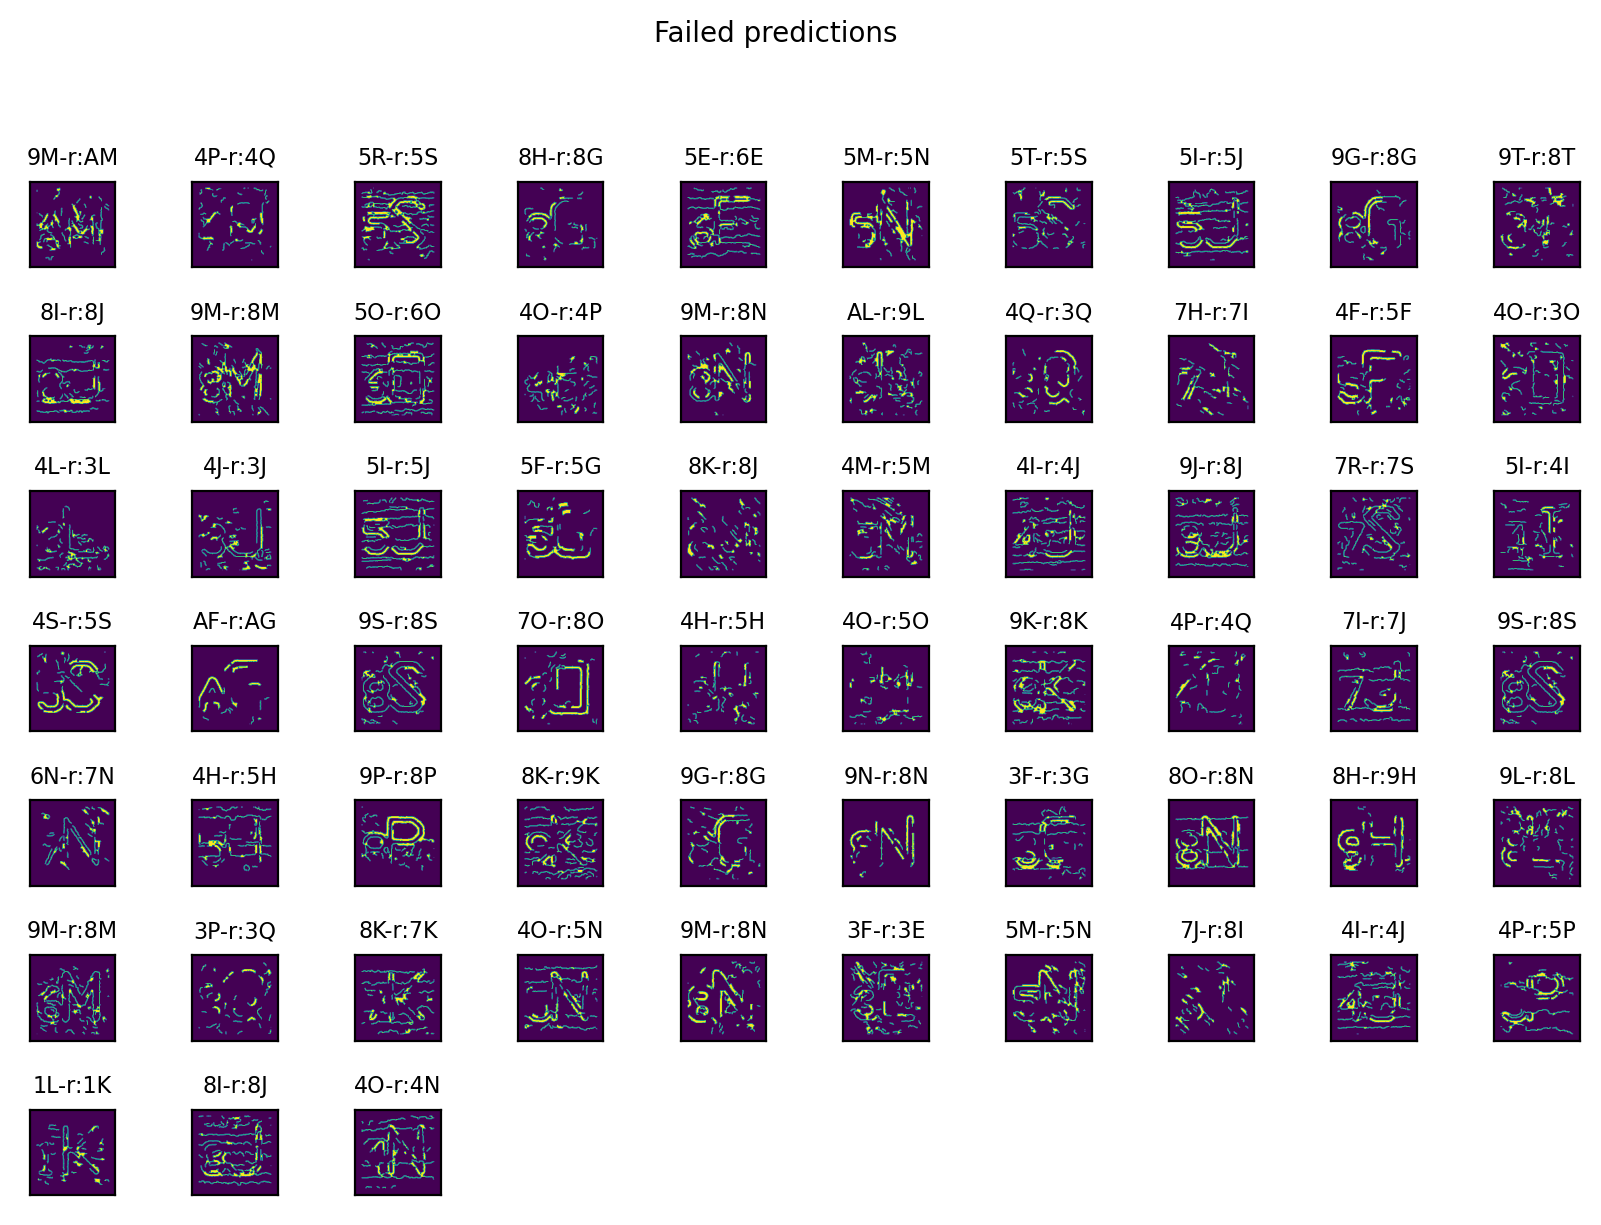

In [47]:
# visualize subset of test data plus predictions
rows = int(np.ceil(a/10))
fig = plt.figure(figsize=(10,rows),dpi=200)

for i in range(0,a):
    index = bad_indexes[i]
    ax = fig.add_subplot(rows, 10, i+1)
    ax.set_title(str(my_letters[final_predictions[index]])+"-r:"+str(my_letters[final_list[index]]),fontsize=8)
    ax.set_xticklabels(())
    ax.set_xticks([])
    ax.set_yticklabels(())
    ax.set_yticks([])
    img = final_tensors[index,:,:,0]
    ax.imshow(img)
fig.suptitle('Failed predictions \n', fontsize=10)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.9, hspace=None)
plt.show()


Finally, we try a difficult test dataset(real) not included in the extracted dataset. This dataset was obtained from a real experiment. We observe the need to restrict the neighborhood to increase the accuracy, since real data is usually much more challenging and noisy than synthetic one. The script _mattek_helper.py_ contains the auxiliary functions here shown, ready to load and execute the model. 

In [48]:
tensors_final_test, _ = load_dataset('.\\data\\Test1')
final_tensors = paths_to_tensor(tensors_final_test)
final_tensors = np.expand_dims(final_tensors, axis=3)

from os.path import split
list_files = [ split(el) for el in tensors_final_test]
final_list = [my_letters.index(el[1][:2].upper()) for el in list_files]

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1886.73it/s]


In [49]:
# Predictions without using neighborhood
final_predictions = [ np.argmax(predictPattern(tensor,model,[])) for ind,tensor in enumerate(final_tensors) ]
test_accuracy = 100*np.sum(np.array(final_predictions)==final_list)/len(final_list)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 56.8627%


In [50]:
neighs = []
for ind in final_list:
   neighs.append(getNeighbors(my_letters[ind],N=1))

final_predictions = [ np.argmax(predictPattern(tensor,model,neighs[ind])) for ind,tensor in enumerate(final_tensors) ]
test_accuracy = 100*np.sum(np.array(final_predictions)==final_list)/len(final_list)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 94.1176%


We can observe, with new data, that we achieved almost a 95% accuracy by restring the area of prediction.